In [ ]:
from collections import Counter
import json
import pandas as pd
import numpy as np

with open("../data/final_dataset_output.json", "r") as f:
    raw_data = json.load(f)
    
with open("../data/final_dataset.json", "r") as f:
    orig_data = json.load(f)
    
print(orig_data[0].keys())

toxicity_per_uid = {d["uid"]: d["toxic"] for d in raw_data}
prompts_per_uid = {d["uid"]: d["prompt"] for d in raw_data}
orig_prompts_per_uid = {d["uid"]: d["prompt"] for d in orig_data}

def relabel(data, target_fp):
    """
    Relabel the data based on the target false positive rate
    Methodology: order the benign data in the test set by confidence score, and select an appropriate theshold
    """
    benign_data = data[data["label"] == 0]
    benign_data = benign_data.sort_values("confidence")

    # Determine the index at which to split the data
    split_index = int(len(benign_data) * (1-target_fp))
    
    # Get the threshold confidence score
    threshold = benign_data.iloc[split_index]["confidence"]
    
    # print("Number of benign samples: ", len(benign_data))
    # print("Threshold confidence score: ", threshold)
    
    # Relabel the data based on the threshold
    data["prediction"] = (data["confidence"] > threshold).astype(int)
            
    return data 
    

def extract_model_subsets(data_path, base=False, target_fp=-1):
    """
    Extract two subsets from ML model evaluation data
    
    Parameters:
    -----------
    data_path : str
        Path to the TSV file containing evaluation data
    
    Returns:
    --------
    tuple of pandas DataFrames
    """
    
    #cutoff  training_size   threshold       timestamp       label   pred    confidence      uid
    # Read the TSV file
    df = pd.read_csv(data_path, sep='\t', header=None, 
                     names=['cutoff_time', 'training_size', 'threshold', 'evaluation_time', 'label', 'prediction', 'confidence', 'uid'])
    
    df['toxic'] = df['uid'].map(toxicity_per_uid)
    df['input'] = df['uid'].map(prompts_per_uid)
    df['orig_input'] = df['uid'].map(orig_prompts_per_uid)
    
    if target_fp > 0:
        df = relabel(df, target_fp)
    
    if base:
        # Find the earliest cutoff time
        earliest_cutoff = df['cutoff_time'].min()
        earliest_cutoff_subset = df[df['cutoff_time'] == earliest_cutoff]
         # Add toxicity labels
        
        return earliest_cutoff_subset

    else:
        # Find the cutoff time closest to the median of all cutoff times
        cutoff_times = df['cutoff_time'].unique()
    
        def find_closest_subset(row):
            # Get cutoff times earlier than the evaluation time
            earlier_cutoffs = [c for c in cutoff_times if c < row['evaluation_time']]
            
            # If no earlier cutoffs exist, return None
            if not earlier_cutoffs:
                return None
            
            # Find the closest cutoff time
            closest_cutoff = min(earlier_cutoffs, key=lambda x: abs(x - row['evaluation_time']))
            return closest_cutoff
        
        # Apply the function to each row
        df['closest_cutoff'] = df.apply(find_closest_subset, axis=1)
        
        # Remove rows where no earlier cutoff exists
        closest_cutoff_subset = df[df['closest_cutoff'].notna()].copy()
        #test = closest_cutoff_subset[closest_cutoff_subset['cutoff_time'] != closest_cutoff_subset['closest_cutoff']]
        #print(test['uid'])
        #closest_cutoff_subset = closest_cutoff_subset[closest_cutoff_subset['cutoff_time'] == closest_cutoff_subset['closest_cutoff']]
        #print(len(closest_cutoff_subset))
        
        return closest_cutoff_subset

def aggregate_model_performance(dataset, time_window=2624016, ignore_non_toxic_jailbreaks=False):
    """
    Aggregate model performance metrics over consecutive time windows.
    
    Parameters:
    -----------
    dataset : pandas.DataFrame
        DataFrame with columns: 'evaluation_time', 'label', 'prediction'
    time_window : float
        Size of time window for aggregation in seconds
    
    Returns:
    --------
    pandas.DataFrame
        Aggregated performance metrics with columns:
        - window_start: Start time of each window
        - false_positive_rate: Proportion of negative labels predicted as positive
        - false_negative_rate: Proportion of positive labels predicted as negative
    """
    # Sort dataset by evaluation time
    df = dataset.sort_values('evaluation_time')
    
    # Calculate window boundaries
    start_time = df['evaluation_time'].min()
    end_time = df['evaluation_time'].max()
    
    # Prepare results storage
    results = []
    
    # Iterate through consecutive windows
    current_window_start = start_time
    while current_window_start < end_time:
        window_end = current_window_start + time_window
        
        # Filter data within current window
        window_data = df[(df['evaluation_time'] >= current_window_start) & 
                         (df['evaluation_time'] < window_end)]
        
        # Skip empty windows
        if len(window_data) == 0:
            current_window_start = window_end
            continue
        
        # Filter data if needed
        if ignore_non_toxic_jailbreaks:
            window_data = window_data[(window_data['label'] == 0) | (window_data['toxic'] == 1)]
        
        # Calculate false positive and false negative rates
        total_negatives = (window_data['label'] == 0).sum()
        total_positives = (window_data['label'] == 1).sum()
        
        false_positives = ((window_data['label'] == 0) & (window_data['prediction'] == 1)).sum()
        false_negatives = ((window_data['label'] == 1) & (window_data['prediction'] == 0)).sum()
        
        false_positive_rate = false_positives / total_negatives if total_negatives > 0 else 0
        false_negative_rate = false_negatives / total_positives if total_positives > 0 else 0
        
        # Store results
        results.append({
            'window_start': current_window_start,
            'false_positive_rate': false_positive_rate,
            'false_negative_rate': false_negative_rate
        })
        
        # Move to next window
        current_window_start = window_end
    
    return pd.DataFrame(results)

def average_model_performance(dataset, ignore_non_toxic_jailbreaks=False):
    """
    Average model performance
    
    Parameters:
    -----------
    dataset : pandas.DataFrame
        DataFrame with columns: 'evaluation_time', 'label', 'prediction'
    
    Returns:
    --------
    Tuple of floats
    """
    # Sort dataset by evaluation time
    df = dataset.sort_values('evaluation_time')
    
    # Filter data if needed
    if ignore_non_toxic_jailbreaks:
        df = df[(df['label'] == 0) | (df['toxic'] == 1)]
        
    # Calculate false positive and false negative rates
    total_negatives = (df['label'] == 0).sum()
    total_positives = (df['label'] == 1).sum()

    false_positives = ((df['label'] == 0) & (df['prediction'] == 1)).sum()
    false_negatives = ((df['label'] == 1) & (df['prediction'] == 0)).sum()

    false_positive_rate = false_positives / total_negatives if total_negatives > 0 else 0
    false_negative_rate = false_negatives / total_positives if total_positives > 0 else 0

    #  Return results
    return false_positive_rate, false_negative_rate



dict_keys(['uid', 'pre_wildchat', 'date', 'prompt', 'source', 'timestamp', 'label'])


In [15]:
### Plot percentile confidence over N day window for both positive and negative points with baseline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from datetime import datetime, timedelta

data = {i: extract_model_subsets(f"../results/base_new_{i}.tsv", base=False) for i in range(1, 10)}
confidences = {row['uid']: [] for _, row in data[1].iterrows()}
timstamps = {row['uid']: 0 for _, row in data[1].iterrows()}
labels_raw = {row['uid']: row['label'] for _, row in data[1].iterrows()}
for _, data_subset in data.items():
    for _, row in data_subset.iterrows():
        confidences[row['uid']].append(row['confidence'])
        timstamps[row['uid']] = row['evaluation_time']

confidences = {uid: np.mean(conf) for uid, conf in confidences.items() if len(conf) > 0}

sorted_confidences = sorted(confidences.items(), key=lambda x: timstamps[x[0]])
uids_sorted, sorted_confidences = zip(*sorted_confidences)
sorted_timestamps = [timstamps[uid] for uid in uids_sorted]
labels = [labels_raw[uid] for uid in uids_sorted] 

positive_confidences = [conf for lab, conf in zip(labels, sorted_confidences) if lab]
negative_confidences = [conf for lab, conf in zip(labels, sorted_confidences) if not lab]
positive_timestamps = [ts for lab, ts in zip(labels, sorted_timestamps) if lab]
negative_timestamps = [ts for lab, ts in zip(labels, sorted_timestamps) if not lab]

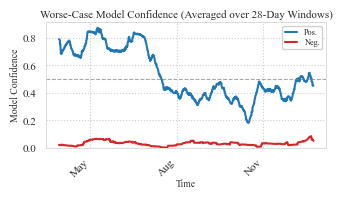

In [22]:
# Convert timestamps to datetime objects
def convert_to_datetime(timestamps):
    return [datetime.fromtimestamp(ts) if isinstance(ts, (int, float)) else ts for ts in timestamps]

pos_dates = convert_to_datetime(positive_timestamps)
neg_dates = convert_to_datetime(negative_timestamps)

# Function to calculate sliding window percentiles with averaging over a larger window
def sliding_window_percentile_with_averaging(values, dates, window_size_n, window_size_m, percentile):
    if not values or not dates:
        return [], []
    
    # Sort by dates in case they're not already sorted
    sorted_pairs = sorted(zip(dates, values), key=lambda x: x[0])
    sorted_dates, sorted_values = zip(*sorted_pairs)
    
    # First calculate percentiles over window N for each point
    raw_percentiles = []
    raw_dates = []
    
    for i in range(len(sorted_values)):
        # Find all points within the inner window N
        end_idx = min(i + window_size_n, len(sorted_values))
        window_values = sorted_values[i:end_idx]
        
        if window_values:
            # Calculate the percentile
            percentile_value = np.percentile(window_values, percentile)
            raw_percentiles.append(percentile_value)
            raw_dates.append(sorted_dates[i])
    
    # Now average these percentiles over the larger window M (in days)
    averaged_percentiles = []
    averaged_dates = []
    
    for i in range(len(raw_dates)):
        current_date = raw_dates[i]
        
        # Define the date range for window M
        start_date = current_date - timedelta(days=window_size_m//2)
        end_date = current_date + timedelta(days=window_size_m//2)
        
        # Find all percentiles within the date range
        window_indices = [j for j in range(len(raw_dates)) 
                         if start_date <= raw_dates[j] <= end_date]
        
        window_percentiles = [raw_percentiles[j] for j in window_indices]
        
        if window_percentiles:
            # Average the percentiles in window M
            avg_percentile = np.mean(window_percentiles)
            averaged_percentiles.append(avg_percentile)
            averaged_dates.append(current_date)
    
    return averaged_dates, averaged_percentiles

# Set the window sizes
window_size_n = 28  # Inner window for percentile calculation (in days)
window_size_m = 28  # Outer window for averaging (in days)

# Set the k value for percentiles
k = 100  # Adjust as needed

# Calculate sliding window percentiles with averaging
pos_window_dates, pos_window_percentiles = sliding_window_percentile_with_averaging(
    positive_confidences, pos_dates, window_size_n, window_size_m, 100 - k)

neg_window_dates, neg_window_percentiles = sliding_window_percentile_with_averaging(
    negative_confidences, neg_dates, window_size_n, window_size_m, k)

# Create figure with subplots for better control over spacing
fig, ax = plt.subplots(figsize=(3.5, 1.8))

# Set the font to Times New Roman with smaller size for column format
# Ensure Times New Roman is used consistently
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'stix'  # For math notation
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
sns.set_style("whitegrid", {'grid.linestyle': ':', 'font.family':'Times New Roman'})

# Plot the sliding window percentiles with thinner lines
ax.plot(pos_window_dates, pos_window_percentiles, color='#1f77b4', linewidth=1.5, 
         label=f'Pos.')
ax.plot(neg_window_dates, neg_window_percentiles, color='#d62728', linewidth=1.5, 
         label=f'Neg.')

# Add a horizontal baseline at 0.5 confidence
ax.axhline(y=0.5, color='#7f7f7f', linestyle='--', linewidth=0.75, alpha=0.7)

# Format the x-axis to show dates compactly
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Just show month abbreviation
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Every 3 months
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees

# Add labels with smaller font and less padding
ax.set_xlabel('Time', fontsize=7, labelpad=0)
ax.set_ylabel('Model Confidence', fontsize=7, labelpad=2)

# Combine the title into a single line to save vertical space
ax.set_title(f'Worse-Case Model Confidence (Averaged over {window_size_n}-Day Windows)', 
             fontsize=8, pad=3)

# Move legend to upper right to take less vertical space
ax.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=6, 
          handlelength=1.5, borderpad=0.3, labelspacing=0.3)

# Set y-axis limits
y_min = min(min(pos_window_percentiles) if pos_window_percentiles else 1, 
            min(neg_window_percentiles) if neg_window_percentiles else 1)
y_max = max(max(pos_window_percentiles) if pos_window_percentiles else 0, 
            max(neg_window_percentiles) if neg_window_percentiles else 0)
margin = (y_max - y_min) * 0.05  # Reduced margin from 10% to 5%
ax.set_ylim([max(0, y_min - margin), min(1, y_max + margin)])

# Cleaner tick formatting with fewer decimals
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.1f}'.format(x)))

# Reduce the number of ticks to avoid crowding
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

# Adjust subplot parameters to maximize plot area
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.2)

# Save the figure in high resolution
plt.savefig('baseline_confidence.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.savefig('baseline_confidence.png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

At threshold=0.5 (0.500):
TPR (Sensitivity): 0.957
FPR: 0.011
Specificity: 0.989


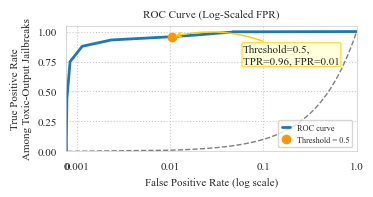

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
import json
from matplotlib.patches import Patch

# Load the data
with open("../data/final_dataset_output.json", "r") as f:
    pipeline_data = json.load(f)
    
true_labels = [d['label'] for d in pipeline_data if d['toxic'] or not d['label']]
scores = [d['toxic_ratio'] for d in pipeline_data if d['toxic'] or not d['label']]

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(true_labels, scores)

# Find the index of the threshold closest to 0.5
threshold_idx = np.argmin(np.abs(thresholds - 0.5))
threshold_value = thresholds[threshold_idx]
fpr_at_threshold = fpr[threshold_idx]
tpr_at_threshold = tpr[threshold_idx]

# Create a figure
plt.figure(figsize=(3.5, 1.8))

# Ensure Times New Roman is used consistently
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'stix'  # For math notation
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
sns.set_style("whitegrid", {'grid.linestyle': ':', 'font.family':'Times New Roman'})

# Plot the ROC curve
plt.plot(fpr, tpr, color='#1f77b4', lw=2, label='ROC curve')

# Plot the point for threshold = 0.5
plt.plot(fpr_at_threshold, tpr_at_threshold, 'o', 
         markersize=6, color='#ff9800', 
         label=f'Threshold = 0.5')

# Set x-axis to symlog scale - linear near zero, logarithmic elsewhere
# This makes small FPR values visible while maintaining overall curve shape
plt.xscale('symlog', linthresh=0.01)

# Add custom ticks for better readability
plt.xticks([0, 0.001, 0.01, 0.1, 1.0], ['0', '0.001', '0.01', '0.1', '1.0'])

# Set axis labels
plt.xlabel('False Positive Rate (log scale)', fontsize=8)
plt.ylabel('True Positive Rate\nAmong Toxic-Output Jailbreaks', fontsize=8)
plt.title('ROC Curve (Log-Scaled FPR)', fontsize=8)

# Add annotation for the threshold point - more compact horizontal layout
plt.annotate(f'Threshold=0.5,\nTPR={tpr_at_threshold:.2f}, FPR={fpr_at_threshold:.2f}',
            xy=(fpr_at_threshold, tpr_at_threshold),
            xytext=(max(fpr_at_threshold+0.05, 0.05), tpr_at_threshold-0.15),
            fontsize=8,
            ha='left',
            va='center',
            bbox=dict(boxstyle='round,pad=0.1', fc='#ffffcc', ec='#ffcc00', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', color='#ffcc00'))

# Draw diagonal line for random classifier
x_diag = np.logspace(-4, 0, 100)
plt.plot(x_diag, x_diag, 'k--', lw=1, alpha=0.5)

# Set axis limits
plt.xlim([0, 1])
plt.ylim([0, 1.05])

# Add legend in a more space-efficient location
plt.legend(loc="lower right", fontsize=6, framealpha=0.8, handlelength=1.0, borderpad=0.4)

# Use a tighter layout with minimal padding
plt.tight_layout(pad=0.1)

# Save the figure with higher resolution
plt.savefig('roc_curve_symlog.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.savefig('roc_curve_symlog.png', dpi=1200, bbox_inches='tight')

# Print metrics for reference
print(f"At threshold=0.5 ({threshold_value:.3f}):")
print(f"TPR (Sensitivity): {tpr_at_threshold:.3f}")
print(f"FPR: {fpr_at_threshold:.3f}")
print(f"Specificity: {1-fpr_at_threshold:.3f}")

plt.show()